# Notebook 4 of 5: *Statistical Analysis*

## Dependencies

Location of files and macros

In [1]:
libname files "/mnt/hgfs/myfolders";
libname macros "/mnt/hgfs/myfolders/macros";

The following macro finds a mean value (%positive cells) for the entire pancreas vs. head, body, and tail.  This is needed for ESM figure 1 & 3, supp table 2, and figure 1.  

In [2]:
%macro mean (A,B);

/*find a mean value (%positive cells) for the entire pancreas vs. head, body, and tail*/

PROC means data=&A nway noprint;
     class case hospbin age_group oppc_ageR;
     var &B;
     output out=&A%quote(_mean) (drop=_type_ _freq_) mean=mean_pancreas;
run;

%mend mean;

## Data Readiness

Import and transform dataset files

### CD45 dataset

In [32]:
DATA cd45;
     set files.cd45;
     if case=6222 or case=6092 or case=6107 then delete; *excluding pilot data from analysis;
run;

PROC sort data = cd45;
     by case match_group hospbin age_group;
run;

PROC transpose data = cd45 out = cd45_no_insulin (rename =( a = Head b = Body c = Tail));
     by case match_group hospbin age_group;
     id sample_type2;
     var percent_cd45;
run;

In [33]:
PROC export data=cd45 
     outfile="cd45.csv" 
     dbms=csv
     replace;
run;

### CD68 dataset

In [4]:
DATA cd68;
     set files.cd68;
     if case=6222 or case=6092 or case=6107 then delete; *excluding pilot data from analysis;
run;

PROC sort data = cd68;
     by case match_group hospbin age_group;
run;

PROC transpose data = cd68 out = cd68_no_insulin (rename=( a=Head b=Body c=Tail));
     by case match_group hospbin age_group;
     id sample_type2;
     var percent_CD68;
run;

### Insulin dataset

In [5]:
DATA insulin;
     set files.insulin;
     if case=6222 or case=6092 or case=6107 then delete; *excluding pilot data from analysis;
run;

PROC sort data = insulin;
     by case match_group hospbin age_group;
run;

PROC transpose data = insulin out = insulin1 (rename =( a = Head b = Body c = Tail));
     by case match_group hospbin age_group;
     id sample_type2;
     var percent_insulin;
run;

proc PRINT data=insulin;
run;

Need to export data for ESM Figure 2 generation

In [6]:
PROC export data=insulin 
     outfile="insulin.csv" 
     dbms=csv
     replace;
run;

### Ki67 dataset

In [7]:
DATA ki67;
     set files.ki67;
     if case=6222 or case=6092 or case=6107 then delete; *excluding pilot data from analysis;
run;

PROC sort data = ki67;
     by case match_group hospbin age_group;
run;

PROC transpose data = ki67 out = ki67_no_insulin (rename = (a = Head b = Body c = Tail));
     by case match_group hospbin age_group;
     id sample_type2;
     var percent_ki67;
run;  

PROC transpose data = ki67 out = ki67_dual (rename = (a = Head b = Body c = Tail));
     by case match_group hospbin age_group;
     id sample_type2;
     var percent_dual;
run; 

Need to export data for ESM Figure 3 generation

In [8]:
PROC export data=ki67 
     outfile="ki67.csv" 
     dbms=csv

replace;
run;

## Statistical Testing

See main text for details.  In brief, p-values from univariate between subjects effects testing are used directly, since it is  not reliant upon the Huynh-Feldt (HF) condition being met.  p-values for within subjects effects testing are determined by first checking for sphericity.  If orthogonal components significant, greenhouse-geisser p-values from univariate within subjects effects table are used.  Otherwise, unadjusted univariate p-values were used for both between and within subjects effects, including the interaction term.

In [9]:
/*6 = '^{unicode 2265}3 to 6 days'  something to do with unicode */
PROC format;
     value $pancorder
     'A' = 'Head'
     'B' = 'Body'
     'C' = 'Tail';
     value hospname
     3 = "<3                             "
     6 = "(*ESC*){unicode '2265'x}3, <6"
     9 = "(*ESC*){unicode '2265'x}6      ";
     value agename
     1 = "<12                              "
     2 = "(*ESC*){unicode '2265'x}12, <20"
     3 = "(*ESC*){unicode '2265'x}20       ";
run;

### CD45 dataset

Statistical analysis model


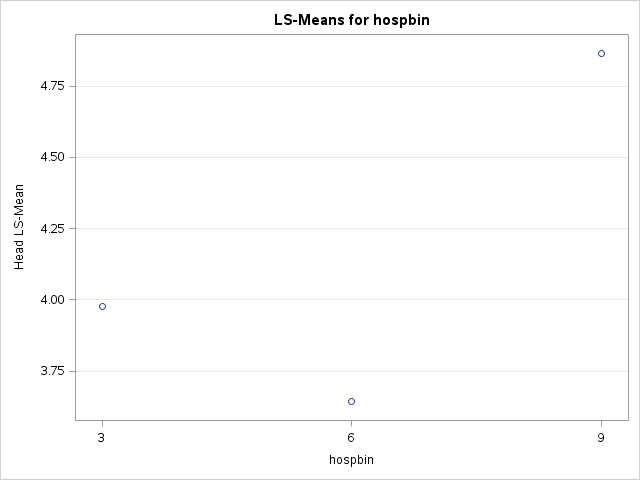
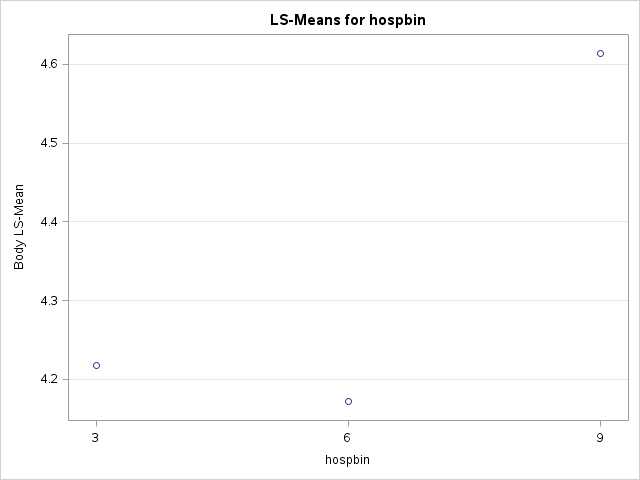
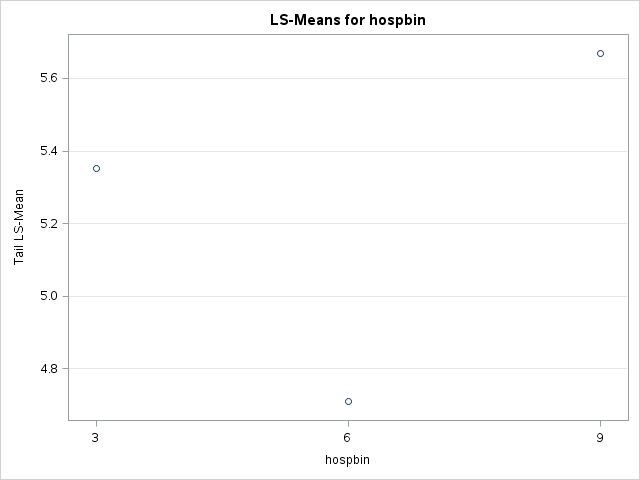
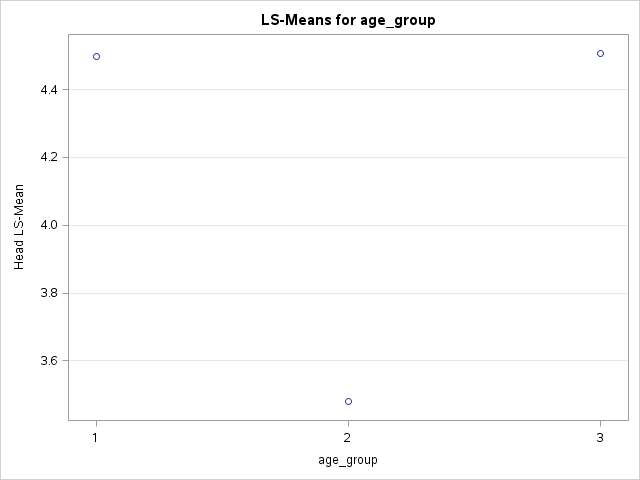
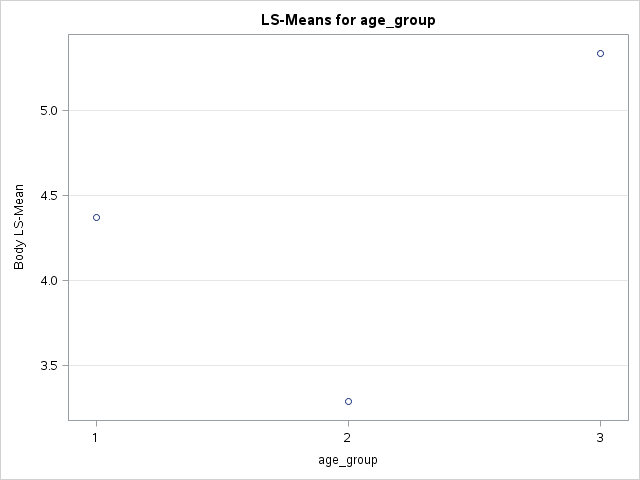
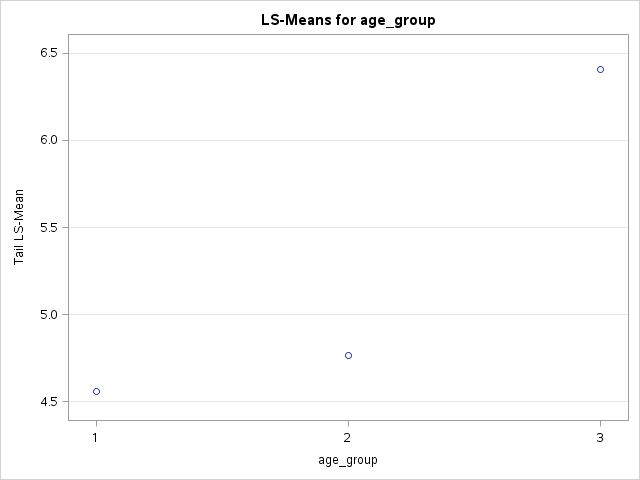
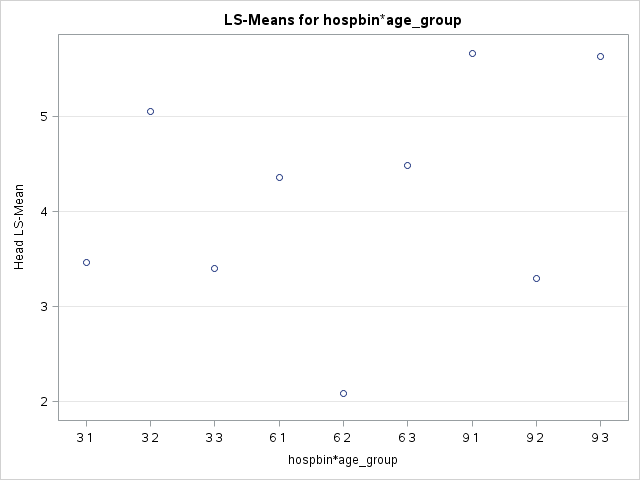
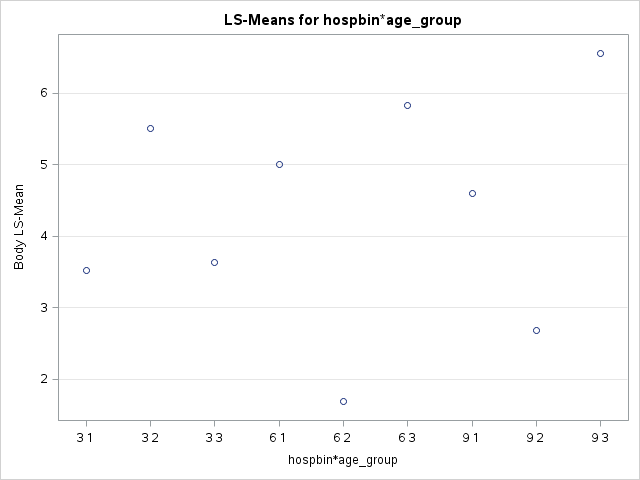
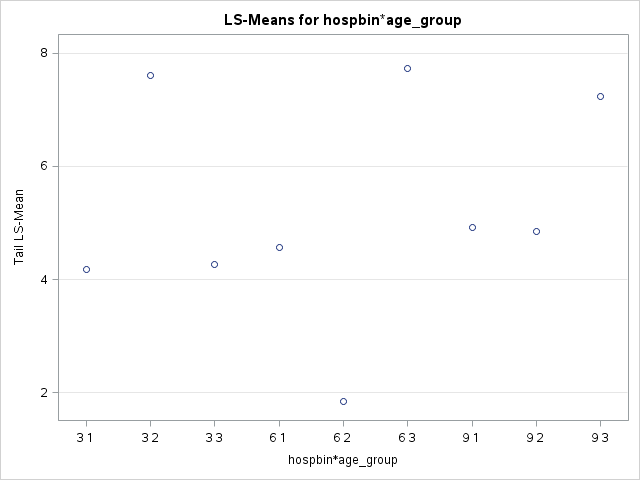

In [10]:
/*to perform sphericity tests and model p-values*/

PROC glm data=cd45_no_insulin;
     class hospbin age_group;
     model Head Body Tail= hospbin|age_group /nouni; 
         *nouni to suppress display of univariate stats;
         *solution not used to display parameter estimates;
         *clparm not used to display confidence limits for parameter estimates;
     repeated sample_type2 / short printe; 
         *short for abbreviated version of output;
         *printe provides e matrix, sphericity tests, partial correlations;
     lsmeans hospbin|age_group / out=cd45_lsmeans (drop=stderr);
run;
quit;



/*to obtain all LSmeans and SE values, perform individual comparisons, retrieve differences and assoc. confidence intervals*/
ods output diffs=cd45_lsmeans_diff;

PROC mixed data=cd45;
     class case hospbin age_group sample_type2;
     model percent_cd45=hospbin|age_group|sample_type2;
     repeated sample_type2/ subject=case(hospbin) type=un;
     lsmeans hospbin|age_group|sample_type2 /adjust=tukey cl pdiff alpha=0.05;
run;

ods output close;

Data for supplemental table 2 and Figure 1

In [11]:
/*ls means values by head body and tail*/

DATA cd45_lsmeans1 (drop=age_group);
     set cd45_lsmeans;
     if age_group^="" then delete;
     stain="CD45           ";
     rename _NAME_=pancreas_region;
run;

PROC print data=cd45_lsmeans1;
run;

/*grand mean values*/

PROC means data=cd45_lsmeans1 mean;
     var lsmean;
     class hospbin;
     output out=cd45_grandmean;
run;

DATA cd45_grandmean (drop=_type_ _freq_ _stat_);
     set cd45_grandmean;
     if _stat_^="MEAN" then delete;
     if hospbin="" then delete;
     pancreas_region="Overall";
     stain="CD45           ";
run;

/*combine files into 1*/

DATA cd45_fig1;
     set cd45_lsmeans1 cd45_grandmean;
run;

PROC print data=cd45_fig1;
run;

Data for figure 2

Figure 2A generation

In [12]:
/*boxplots of staining levels grouped by panc region*/

PROC sort data=cd45;
    by sample_type2;
run;

PROC means data=cd45 mean std median min max;
     var percent_cd45;
     by sample_type2;
run;

DATA long_cd45;
     set cd45;
     stain="CD45     ";
     percent_cells=percent_cd45;
output;

     stain="Insulin";
        percent_cells=percent_insulin;
output;

     stain="Negative";
     percent_cells=percent_negative;
output;

     drop percent_cd45 percent_insulin percent_negative;
run;


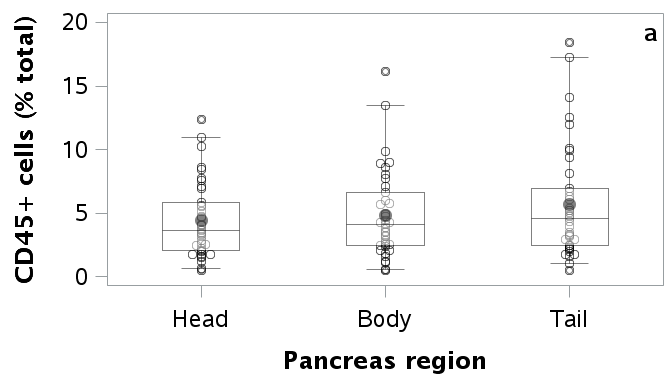

In [13]:
ODS GRAPHICS ON / reset = all height= 4 in width=7 in border= off imagename="Fig2A";
ods listing image_dpi=600;

PROC sgplot data=long_cd45 (where=(stain = 'CD45')) noautolegend;
     format sample_type2 $pancorder.;
     styleattrs datacolors=(white) datacontrastcolors=(black);
     scatter x=sample_type2 y=percent_cells/ group=stain name="Circles" jitter MARKERATTRS=(symbol=circle size=10) MARKEROUTLINEATTRS=(thickness=1) transparency=0.4;
     vbox percent_cells / whiskerpct=5 /*95% percentile*/ category=sample_type2 group=stain transparency=0.50 meanattrs=(color=black symbol=circlefilled size=14) fillattrs=(color=white transparency=.5);
     yaxis grid;
     xaxis discreteorder=data labelattrs=(size=18) valueattrs=(size=18) label="Pancreas region" labelattrs=(size = 19 Family=Arial weight=bold);
     
     yaxis values=(0 to 20 by 5) labelattrs=(size=18) valueattrs=(size=18) label="CD45+ cells (% total)" labelattrs = (size = 19 Family=Arial weight=bold);
     inset /title= "a" titleattrs=(size=19) titleattrs=(weight=bold) position=topright noborder;
run;

ODS GRAPHICS off;


Figure 2B generation.  Code for figure adapoted from Robin High, University of Nebraska Medical Center and is available [here.](http://support.sas.com/resources/papers/proceedings14/1902-2014.pdf)

In [14]:
/*need to prepare data file*/

DATA differences (drop=hospbin _hospbin age_group _age_group);
     format sample_type2 $pancorder. _sample_type2 $pancorder.;
     set cd45_lsmeans_diff;
     if effect^="sample_type2" then delete;
     if sample_type2="A" then region1="Head";
     if sample_type2="B" then region1="Body";
     if sample_type2="C" then region1="Tail";
     if _sample_type2="A" then region2="Head";
     if _sample_type2="B" then region2="Body";
     if _sample_type2="C" then region2="Tail";
run;

PROC print data=differences;
run;




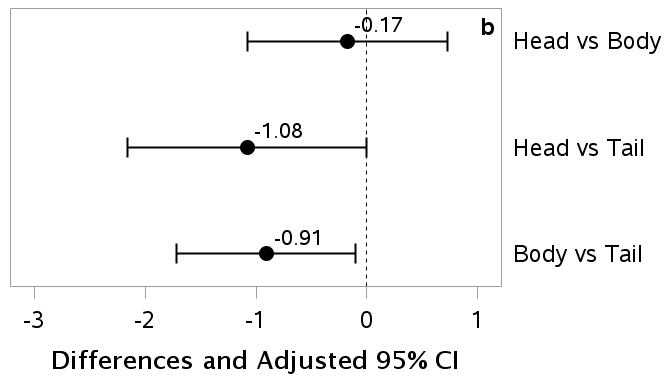

In [15]:
/* Forest Plot of Differences 
with the file of differences add a text variable called label describing each comparison;*/
DATA dfs2;
     SET differences (rename=(estimate=mndif1 adjlower=adjlower1 adjupper=adjupper1));
     DROP ptxt;
     LENGTH label $30 ptxt $4;
     IF pvalue < .001 then ptxt=', p='; else ptxt=', p=';
     label = CAT(put(region1,4.),' vs ',
     put(region2,4.));
     * new variables for non-significant differences, set existing to missing;
     IF (pvalue GE 0.05) then do;
     mndif2 = mndif1; adjlower2 = adjlower1; adjupper2 =adjupper1;
     mndif1 = . ; adjlower1 = . ; adjupper1 = . ;
     end;
RUN;

PROC print data=dfs2;
run;

ODS GRAPHICS ON / reset = all height= 4 in width=7 in border= off imagename="Fig2B";
ods listing image_dpi=600;

PROC sgplot data=dfs2 noautolegend;
     REFLINE 0 / axis=x lineattrs=(color=black pattern=2 thickness=1) transparency=0;
     
     SCATTER y=label x=mndif1 / xerrorlower=adjlower1 xerrorupper=adjupper1
     errorbarattrs=(color=black pattern=1 thickness=2)
     markerattrs=(color=black symbol= circlefilled size=16)
     datalabel=mndif1 datalabelattrs=(color=black size=16) y2axis;
     
     /* print the differences at the center of each confidence interval */
     
     SCATTER y=label x=mndif2 / xerrorlower=adjlower2 xerrorupper=adjupper2
     
     markerattrs=(color=black symbol= circlefilled size=16)
     datalabel=mndif2 datalabelattrs=(color=black size=16) y2axis;
     
     XAXIS offsetmin=0.05 offsetmax=0.05 label='Differences and Adjusted 95% CI' labelattrs=(size = 18 Family=Arial weight=bold) values=(-3 to 1 by 1) valueattrs=(size=18);
     Y2AXIS offsetmin=0.12 offsetmax=0.12 display=(Nolabel Noticks) reverse labelattrs=(size=18) valueattrs=(size=18);
     
     inset /title= "b" titleattrs=(size=18) titleattrs=(weight=bold) position=topright noborder;
     FORMAT mndif1 mndif2 5.2;
     title ;
run;

ODS GRAPHICS off;


To combine 2a and 2b into one figure, take png files and combine in inkscape at 1100mm width, 379mm height, 600 dpi. From there, use online image converter to change from png to eps. 

### CD68 dataset

statistical analysis model


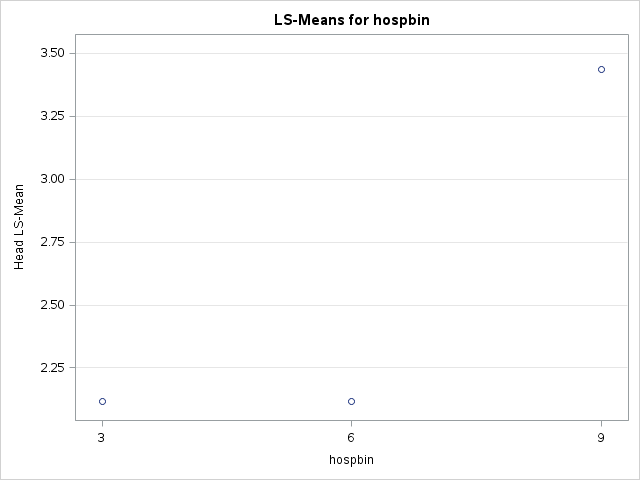
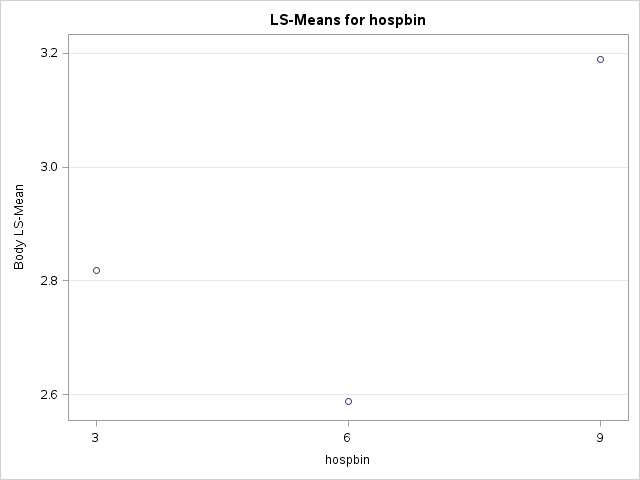
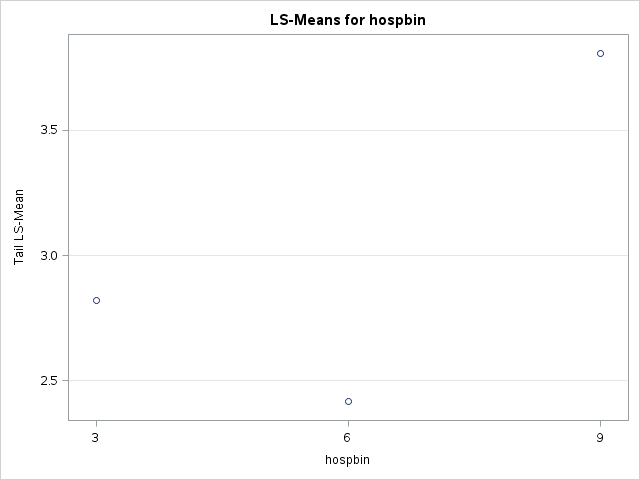
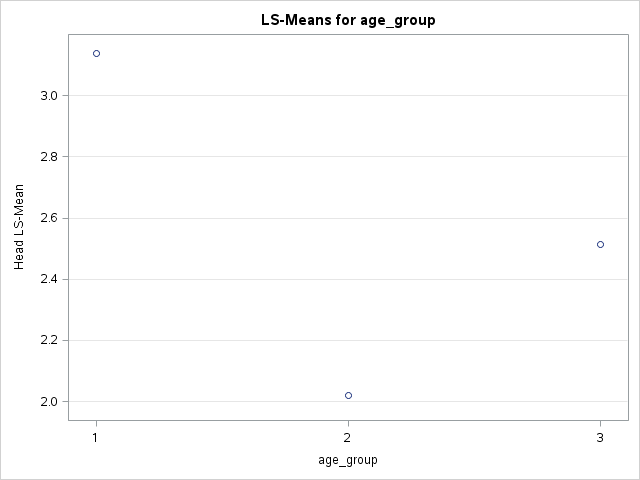
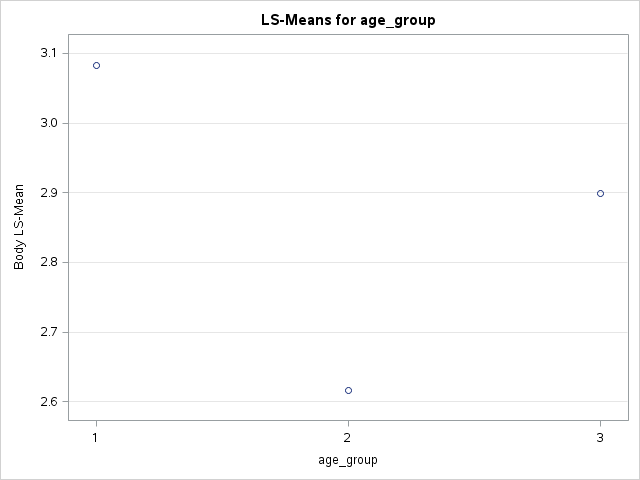
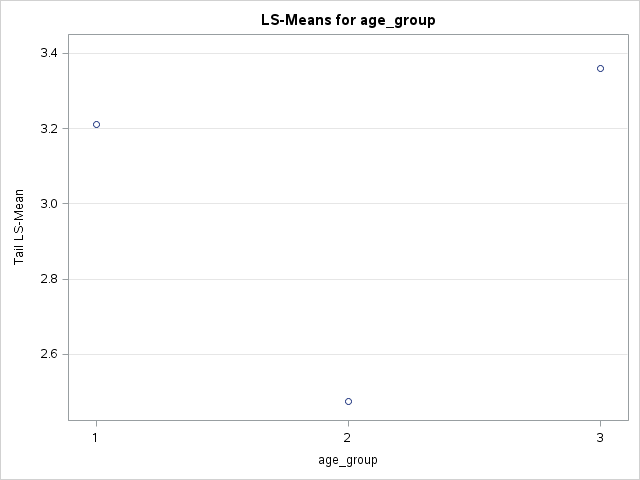
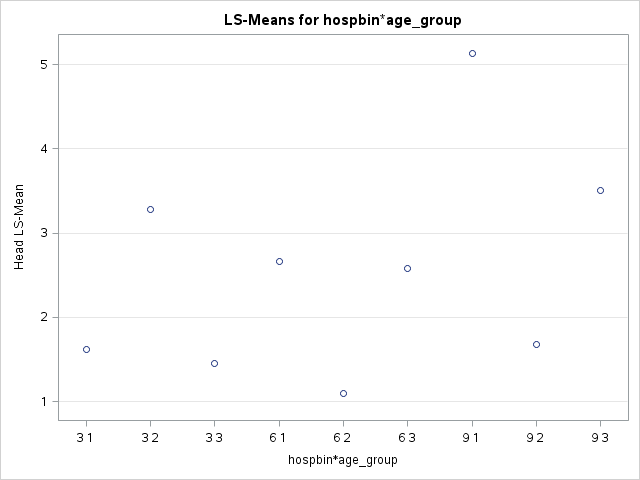
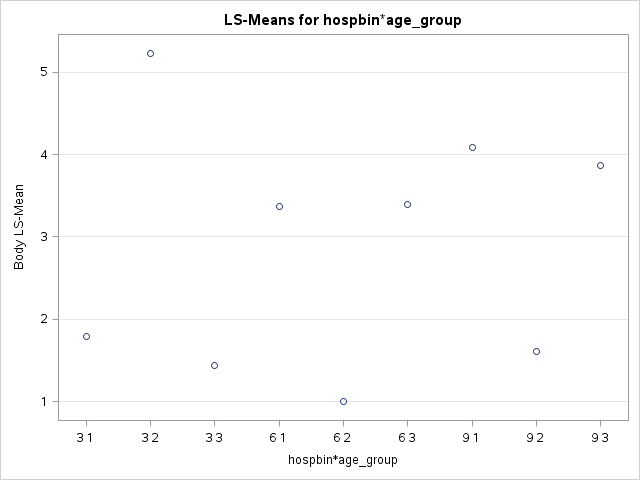
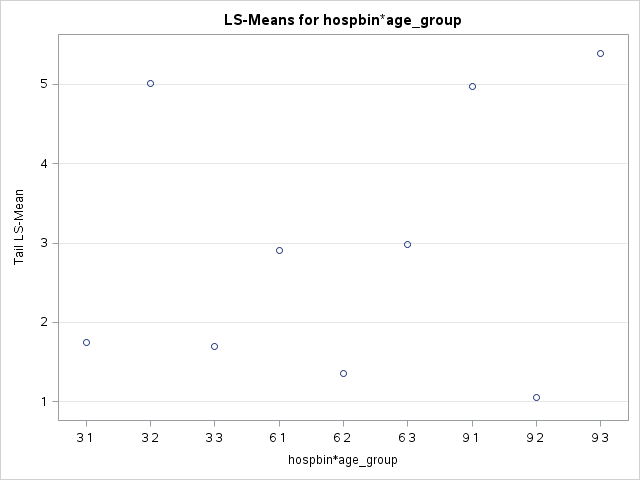

In [16]:
PROC glm data=cd68_no_insulin;
     class hospbin age_group;
     model Head Body Tail= hospbin|age_group/nouni; 
     repeated sample_type2 / short printe; 
     lsmeans hospbin|age_group /out=cd68_lsmeans (drop=stderr);
run;
quit;

PROC mixed data=cd68;
     class case hospbin age_group sample_type2;
     model percent_cd68=hospbin|age_group|sample_type2;
     repeated sample_type2/ subject=case(hospbin) type=un;
     lsmeans hospbin|age_group|sample_type2 /adjust=tukey cl pdiff alpha=0.05;
run;


Data for supplemental table 2 and Figure 1

In [17]:
/*ls means values by head body and tail*/

DATA cd68_lsmeans1 (drop=age_group);
     set cd68_lsmeans;
     if age_group^="" then delete;
     stain="CD68           ";
     rename _NAME_=pancreas_region;
run;

PROC print data=cd68_lsmeans1;
run;

/*grand mean values*/

PROC means data=cd68_lsmeans1 mean;
     var lsmean;
     class hospbin;
     output out=cd68_grandmean;
run;

DATA cd68_grandmean (drop=_type_ _freq_ _stat_);
     set cd68_grandmean;
     if _stat_^="MEAN" then delete;
     if hospbin="" then delete;
     pancreas_region="Overall";
     stain="CD68           ";
run;

/*combine files into 1*/

DATA CD68_fig1;
     set CD68_lsmeans1 CD68_grandmean;
run;

PROC print data=CD68_fig1;
run;

### Insulin dataset

statistical analysis model


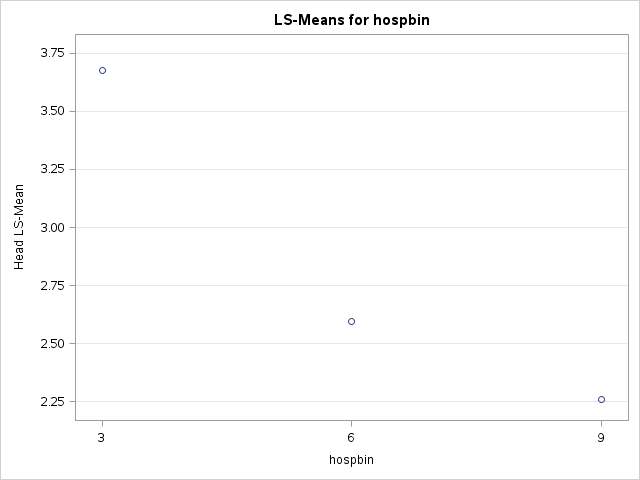
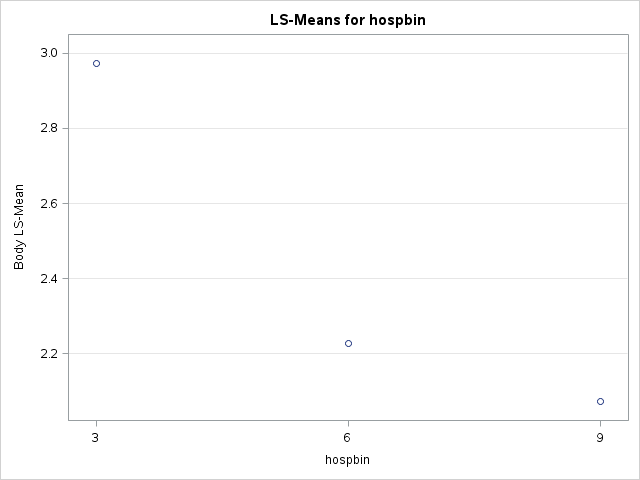
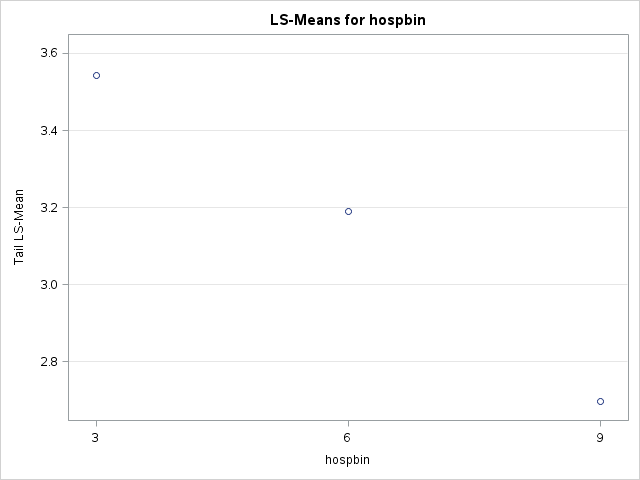
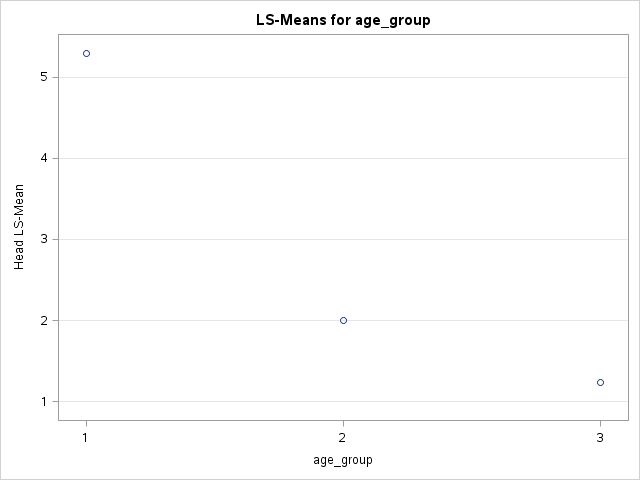
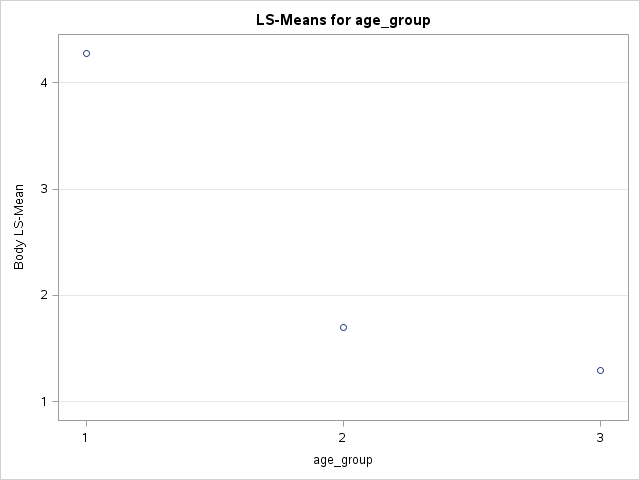
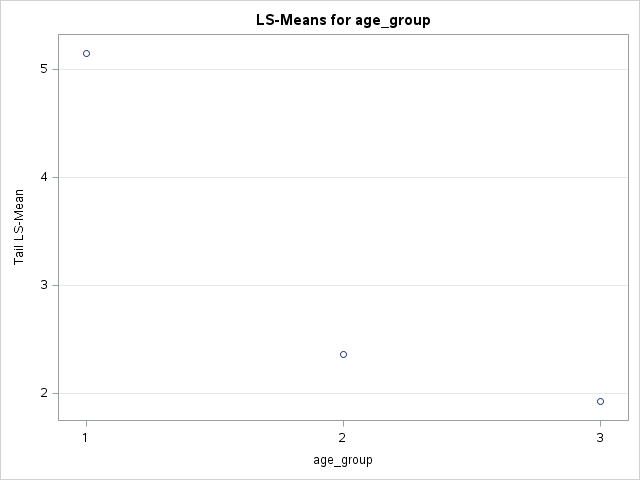
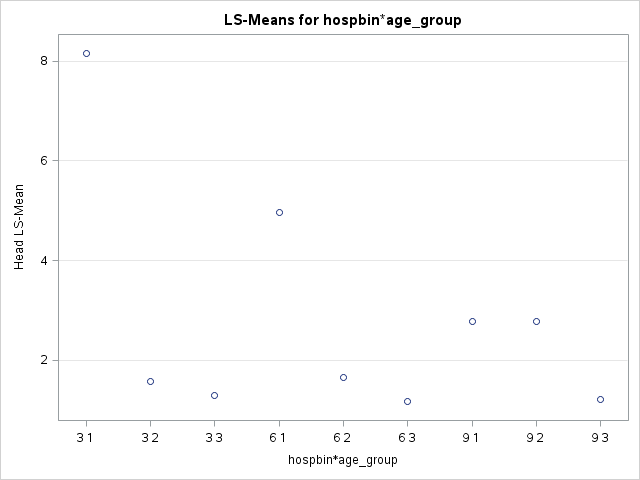
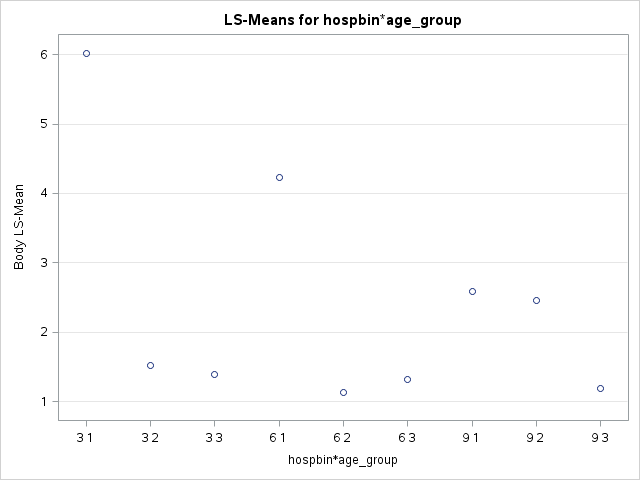
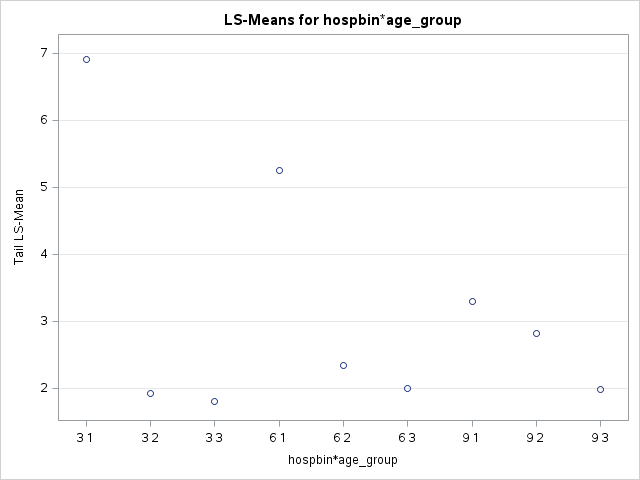

In [18]:
PROC glm data=insulin1;
     class hospbin age_group;
     model Head Body Tail= hospbin|age_group/nouni; 
     repeated sample_type2 / short printe; 
     lsmeans hospbin|age_group / out=insulin1_means (drop=stderr);
run;
quit;

PROC mixed data=insulin;
     class case hospbin age_group sample_type2;
     model percent_insulin=hospbin|age_group|sample_type2;
     repeated sample_type2/ subject=case(hospbin) type=un;
     lsmeans hospbin|age_group|sample_type2 /adjust=tukey cl pdiff alpha=0.05;
run;



Data for supplemental table 2 and Figure 1

In [19]:
/*ls means values by head body and tail*/

DATA insulin1_lsmeans1 (drop=age_group);
     set insulin1_means;
     if age_group^="" then delete;
     stain="Insulin           ";
     rename _NAME_=pancreas_region;
run;

PROC print data=insulin1_lsmeans1;
run;

/*grand mean values*/

PROC means data=insulin1_lsmeans1 mean;
     var lsmean;
     class hospbin;
     output out=insulin1_grandmean;
run;

DATA insulin1_grandmean (drop=_type_ _freq_ _stat_);
     set insulin1_grandmean;
     if _stat_^="MEAN" then delete;
     if hospbin="" then delete;
     pancreas_region="Overall";
     stain="Insulin           ";
run;

/*combine files into 1*/

DATA insulin1_fig1;
     set insulin1_lsmeans1 insulin1_grandmean;
run;

PROC print data=insulin1_fig1;
run;

### Ki67 alone dataset

statistical analysis model


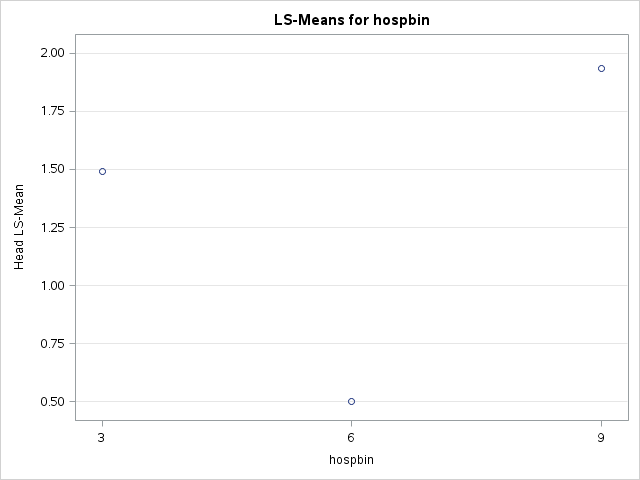
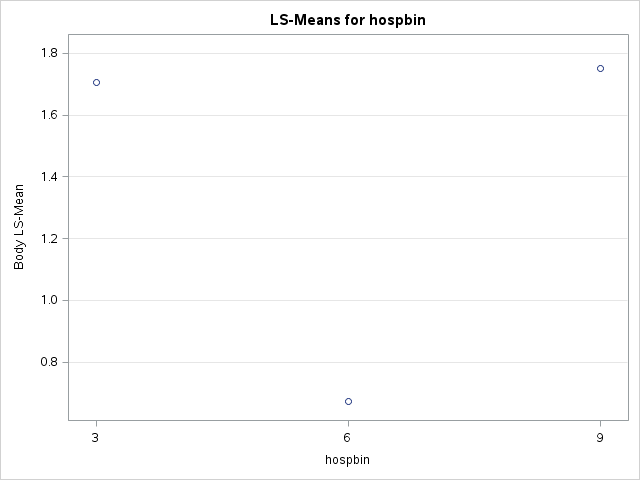
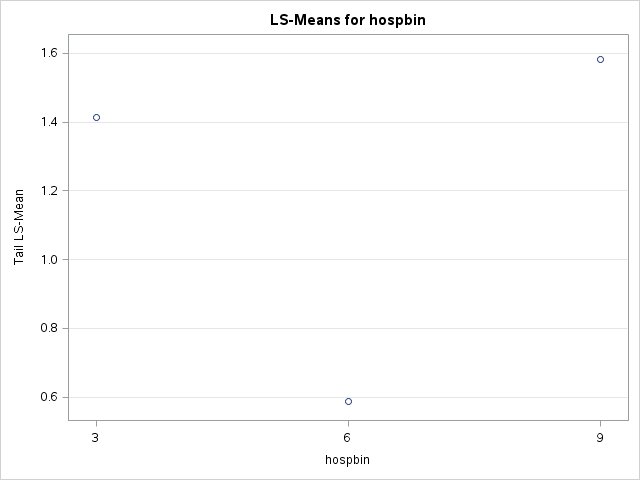
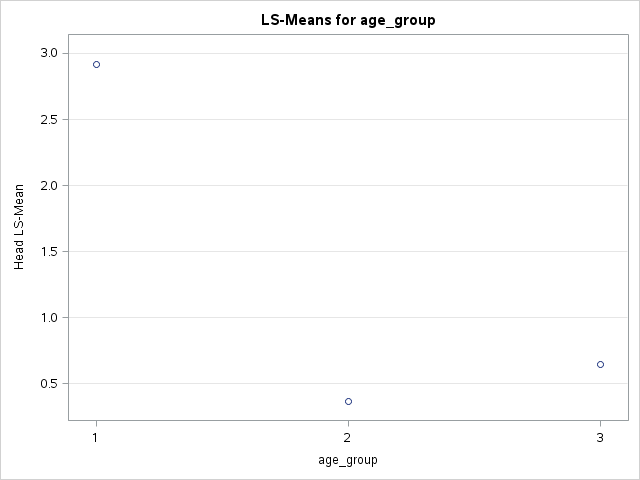
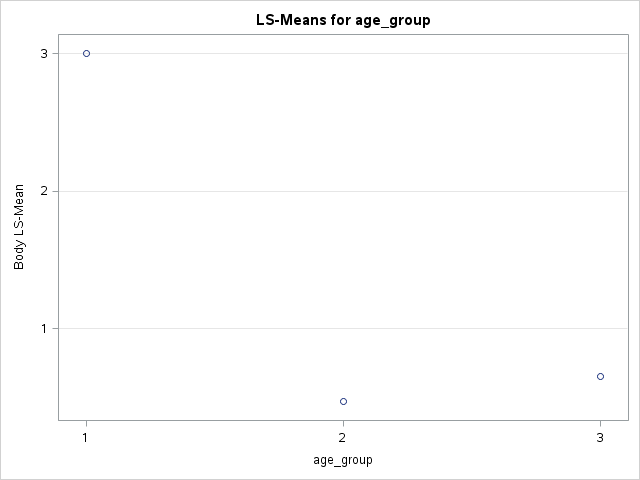
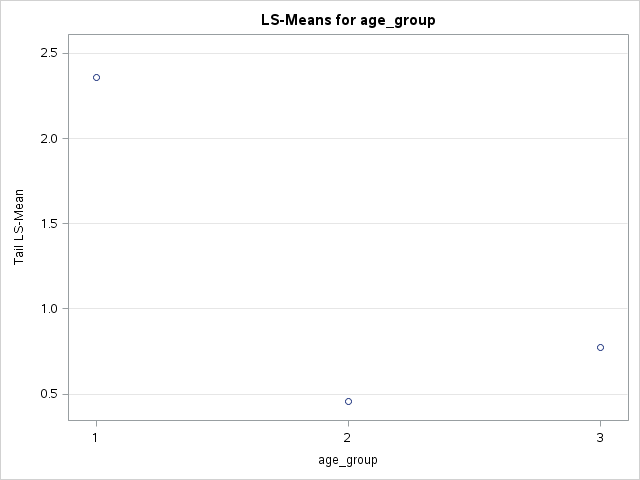
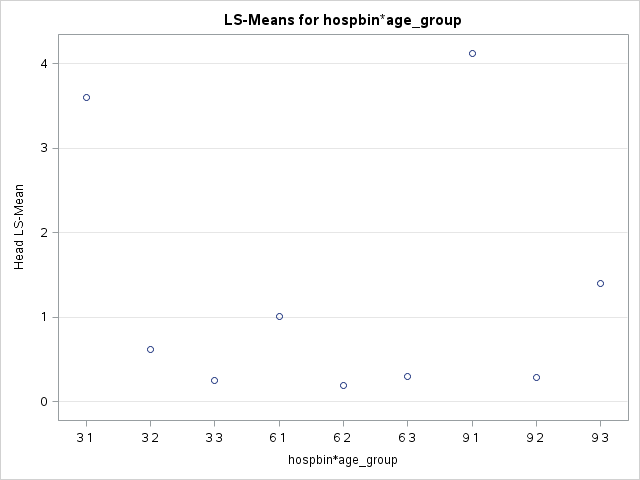
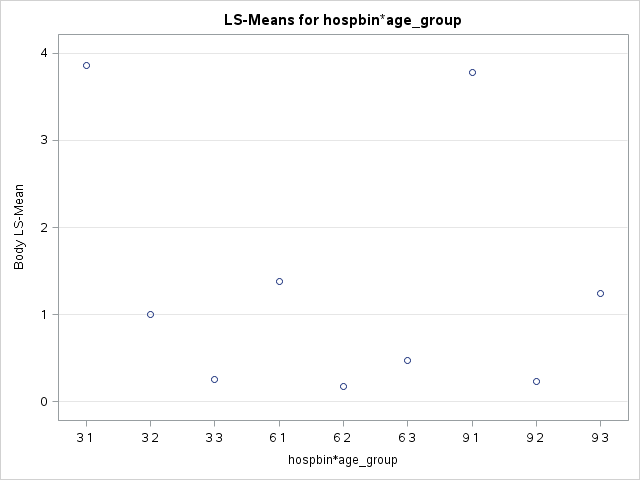
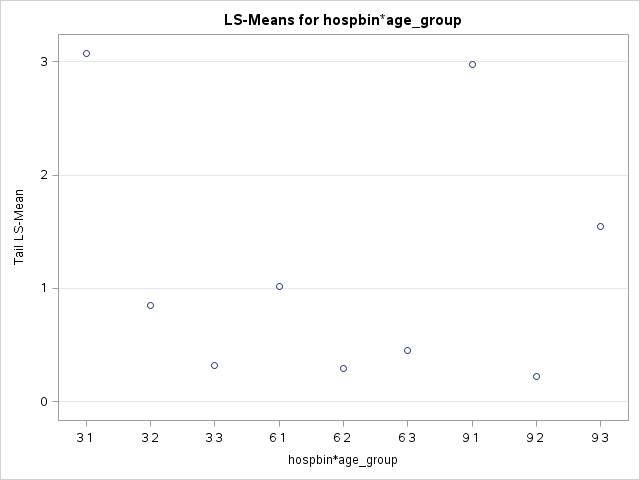

In [20]:
PROC glm data=ki67_no_insulin;
     class hospbin age_group;
     model Head Body Tail= hospbin|age_group/nouni; 
     repeated sample_type2 / short printe; 
     lsmeans hospbin|age_group /out=ki67_lsmeans (drop=stderr);
run;
quit;

PROC mixed data=ki67;
     class case hospbin age_group sample_type2;
     model percent_ki67=hospbin|age_group|sample_type2;
     repeated sample_type2/ subject=case(hospbin) type=un;
     lsmeans hospbin|age_group|sample_type2 /adjust=tukey cl pdiff alpha=0.05;
run;


Data for supplemental table 2 and Figure 1

In [21]:
/*ls means values by head body and tail*/

DATA ki67_lsmeans1 (drop=age_group);
     set ki67_lsmeans;
     if age_group^="" then delete;
     stain="Ki67          ";
     rename _NAME_=pancreas_region;
run;

PROC print data=ki67_lsmeans1;
run;

/*grand mean values*/

PROC means data=ki67_lsmeans1 mean;
     var lsmean;
     class hospbin;
     output out=ki67_grandmean;
run;

DATA ki67_grandmean (drop=_type_ _freq_ _stat_);
     set ki67_grandmean;
     if _stat_^="MEAN" then delete;
     if hospbin="" then delete;
     pancreas_region="Overall";
     stain="Ki67           ";
run;

/*combine files into 1*/

DATA ki67_fig1;
     set ki67_lsmeans1 ki67_grandmean;
run;

PROC print data=ki67_fig1;
run;

### Ki67/Insulin (dual) dataset

statistical analysis model


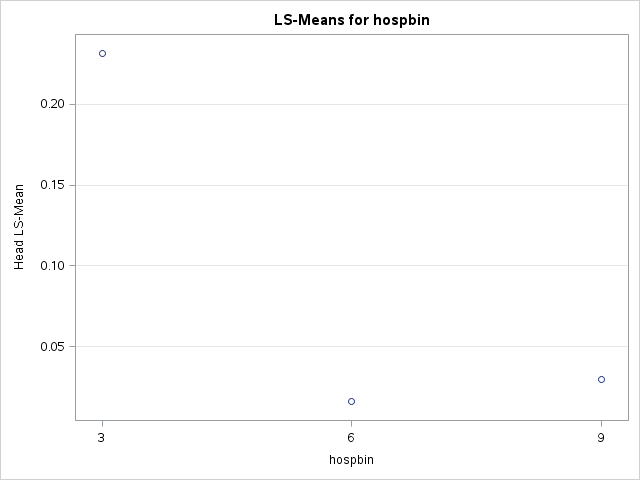
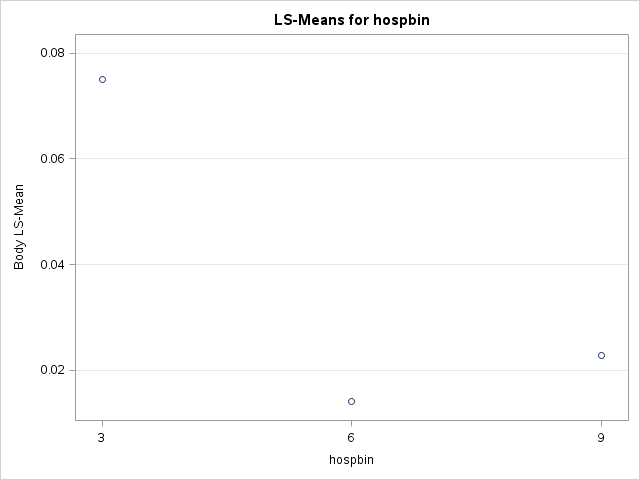
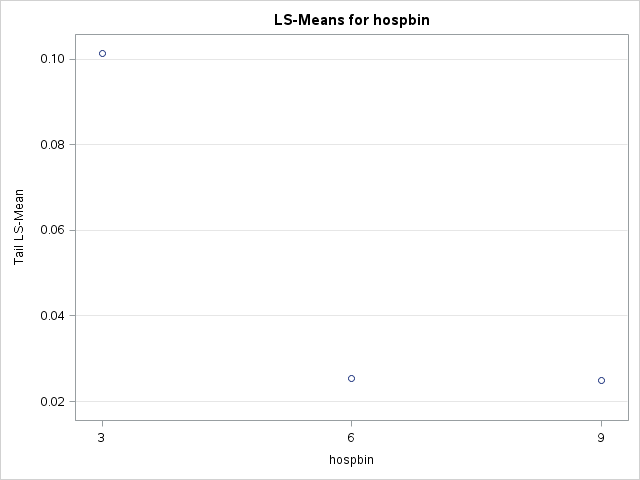
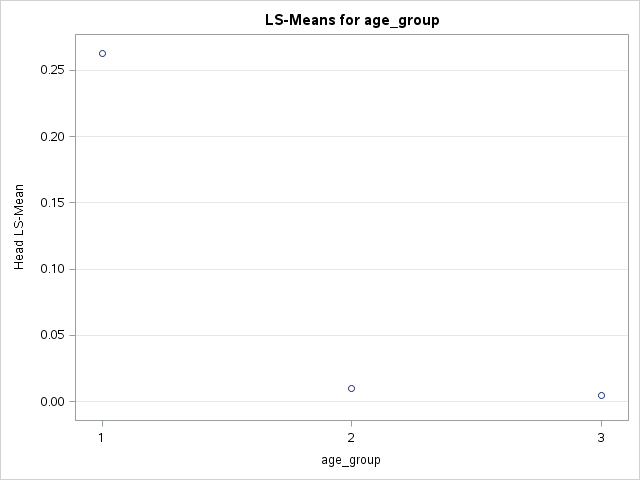
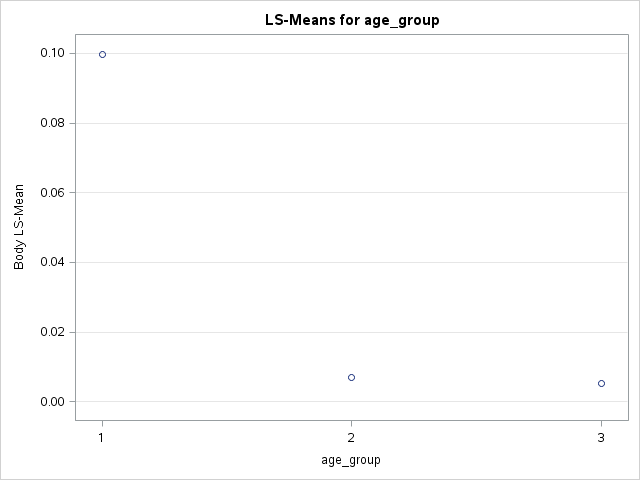
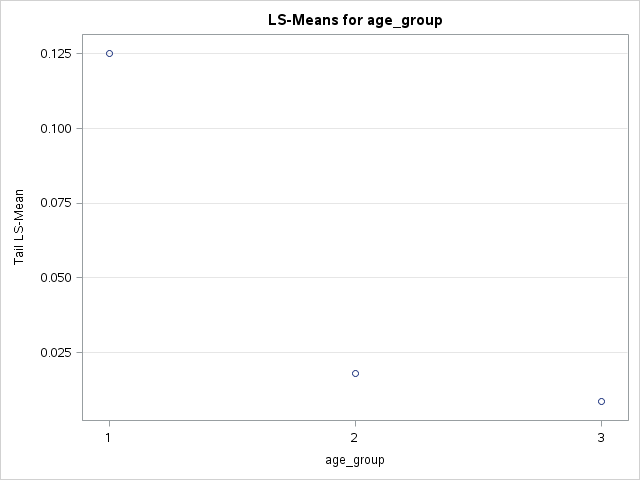
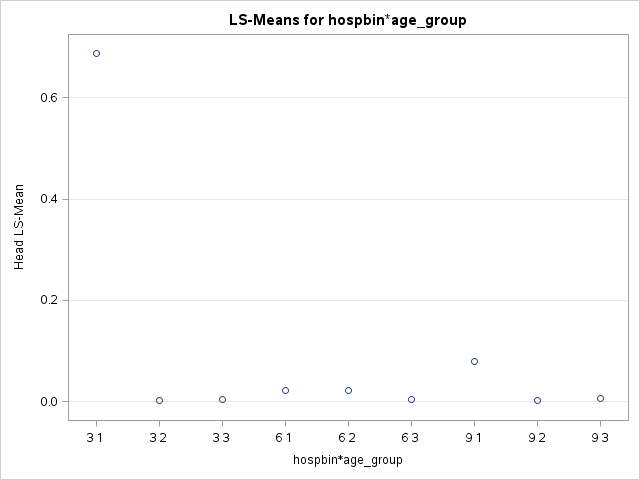
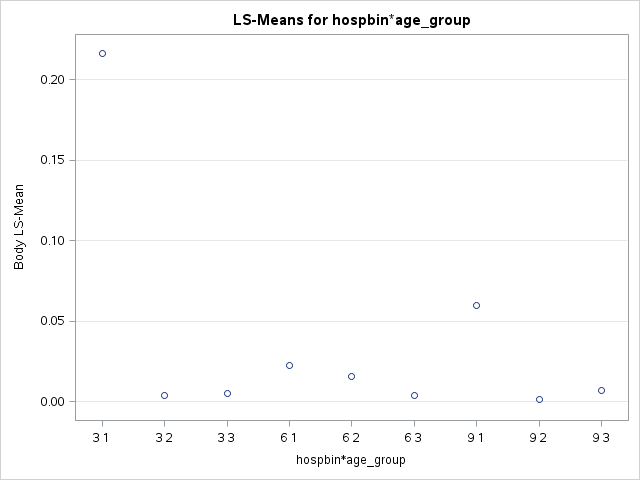
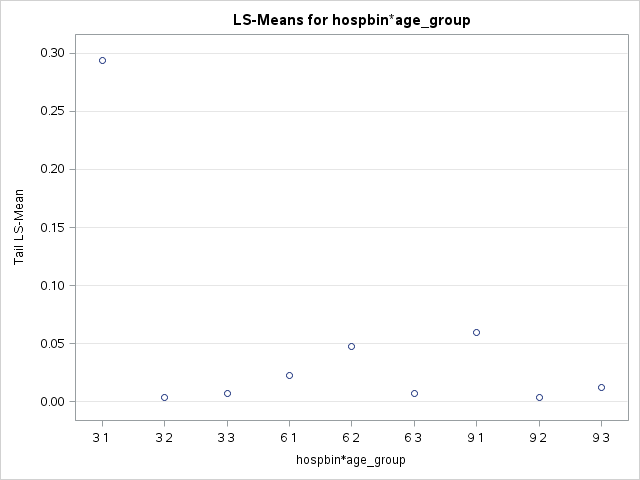

In [24]:
PROC glm data=ki67_dual;
     class hospbin age_group;
     model Head Body Tail= hospbin|age_group/nouni; 
     repeated sample_type2 / short printe; 
     lsmeans hospbin|age_group / out=dual_lsmeans(drop=stderr);
run;
quit;

PROC mixed data=ki67;
     class case hospbin age_group sample_type2;
     model percent_dual=hospbin|age_group|sample_type2;
     repeated sample_type2/ subject=case(hospbin) type=un;
     lsmeans hospbin|age_group|sample_type2 /adjust=tukey cl pdiff alpha=0.05;
run;


data for supplemental table 2 and figure 1

In [25]:
/*ls means values by head body and tail*/

DATA dual_lsmeans1 (drop=age_group);
     set dual_lsmeans;
     if age_group^="" then delete;
     stain="dual           ";
     rename _NAME_=pancreas_region;
run;

PROC print data=dual_lsmeans1;
run;

/*grand mean values*/

PROC means data=dual_lsmeans1 mean;
     var lsmean;
     class hospbin;
     output out=dual_grandmean;
run;

DATA dual_grandmean (drop=_type_ _freq_ _stat_);
     set dual_grandmean;
     if _stat_^="MEAN" then delete;
     if hospbin="" then delete;
     pancreas_region="Overall";
     stain="dual           ";
run;

/*combine files into 1*/

DATA dual_fig1;
     set dual_lsmeans1 dual_grandmean;
run;

PROC print data=dual_fig1;
run;

### All datasets

data for figure 1

In [26]:
DATA figure1;
     set cd45_fig1 cd68_fig1 insulin1_fig1 ki67_fig1 dual_fig1;
run;

proc print data=figure1;
run;

PROC export data=figure1 
     outfile="figure1.csv" 
     dbms=csv
     replace;
run; 

ESM Figure 1 interaction plot panel for hospitalization time by age group interaction

In [30]:
proc print data=cd45_mean;
run;

proc print data=insulin_mean;
run;


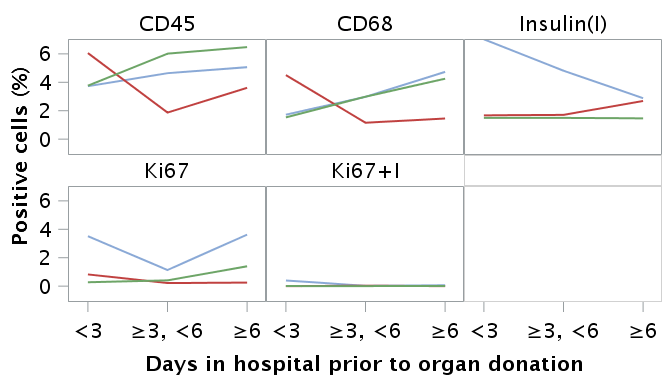

In [27]:
/*to determine a mean value for each combination of hospitalization by age group combination*/

%mean(cd45,percent_cd45);
PROC sort data=cd45_mean;
     by hospbin age_group;
run;
PROC univariate data=cd45_mean;
     by hospbin age_group;
     var mean_pancreas;
     output out=cd45_interaction mean=mean_pancreas_group;
run;
DATA cd45_interaction;
     set cd45_interaction;
     dataset="CD45      ";
run;

%mean(cd68,percent_cd68);
PROC sort data=cd68_mean;
     by hospbin age_group;
run;
PROC univariate data=cd68_mean;
     by hospbin age_group;
     var mean_pancreas;
     output out=cd68_interaction mean=mean_pancreas_group;
run;
DATA cd68_interaction;
     set cd68_interaction;
     dataset="CD68      ";
run;

%mean(insulin,percent_insulin);
PROC sort data=insulin_mean;
     by hospbin age_group;
run;
PROC univariate data=insulin_mean;
     by hospbin age_group;
     var mean_pancreas;
     output out=insulin_interaction mean=mean_pancreas_group;
run;
DATA insulin_interaction;
     set insulin_interaction;
     dataset="Insulin(I)   ";
run;

%mean(ki67,percent_ki67);
PROC sort data=ki67_mean;
     by hospbin age_group;
run;
PROC univariate data=ki67_mean;
     by hospbin age_group;
     var mean_pancreas;
     output out=ki67_interaction mean=mean_pancreas_group;
run;
DATA ki67_interaction;
     set ki67_interaction;
     dataset="Ki67      ";
run;
 
/*did not use macro for dual dataset*/
PROC means data=ki67 nway noprint;
     class case hospbin age_group oppc_ageR;
     var percent_dual;
     output out=ki67dual_mean (drop=_type_ _freq_) mean=mean_pancreas;
run;
PROC sort data=ki67dual_mean;
     by hospbin age_group;
run;
PROC univariate data=ki67dual_mean;
     by hospbin age_group;
     var mean_pancreas;
     output out=ki67dual_interaction mean=mean_pancreas_group;
run;
DATA ki67dual_interaction;
     set ki67dual_interaction;
     dataset="Ki67+I     ";
run;

DATA all_interactions;
     set cd45_interaction cd68_interaction insulin_interaction ki67_interaction ki67dual_interaction;
run;
 
PROC print data=all_interactions;
run;

ODS GRAPHICS ON / reset = all height= 4 in width=7 in border= off imagename="ESM_Fig1";
ods listing image_dpi=600;

PROC sgpanel data=all_interactions noautolegend;
     panelby dataset/novarname noheaderborder headerbackcolor=white headerattrs=(size=16pt Family=Arial) onepanel;
     format hospbin hospname. age_group agename.;
     series x=hospbin y=mean_pancreas_group/ group=age_group name="Lines" LINEATTRS = (THICKNESS = 2.0 pattern=solid);
     styleattrs datacontrastcolors=(cx8AA9D6 cxC04140 cx6DA567);
     colaxis values=(3 to 9 by 3) discreteorder=data labelattrs=(size=16) valueattrs=(size=16 Family=Arial) label="Days in hospital prior to organ donation" labelattrs=(size = 16 weight=bold Family=Arial);
     rowaxis values=(0 to 6 by 1) labelattrs=(size=16) valueattrs=(size=16 Family=Arial) label="Positive cells (%)" labelattrs=(size = 16 weight=bold Family=Arial);
     /*keylegend "Lines"/title= "Age Group" titleattrs=(size=16) titleattrs=(weight=bold) valueattrs=(size=16) valueattrs=(weight=bold) noborder position=right*/;
run;

ODS graphics off;

Reviewer asked about the differences between insulin and CD45 and asked for a comparison; thus the analysis below.  However, the results were not included in the manuscript.  Since none of these CD45+ cells were observed to be in direct proximity to insulin positive cells, this comparison is difficult to interpret without additional data to determine if these CD45+ cells are resident or trafficking cells.    

In [50]:
/*to prepare the data for visualization and analysis*/

DATA cd45_temp (keep = case sample_type2 Positive_cells_percentage stain);
     set cd45;
     Stain="CD45    ";
     rename percent_cd45=Positive_cells_percentage;
run;

DATA insulin_temp (keep = case sample_type2 Positive_cells_percentage stain);
     set cd45;
     Stain="Insulin";
     rename percent_insulin=Positive_cells_percentage;
run;


DATA cd45_insulin;
     set cd45_temp insulin_temp;
     Rename sample_type2=Region;
run;

PROC export data=cd45_insulin 
     outfile="cd45_insulin.csv" 
     dbms=csv
     replace;
run; 

/*to obtain all LSmeans and SE values, perform individual comparisons, retrieve differences and assoc. confidence intervals*/
PROC mixed data=cd45_insulin;
class case stain region;
model positive_cells_percentage=stain|region;
repeated stain/subject=case(region) type=un;
lsmeans region|stain / adjust=tukey cl pdiff alpha=0.05;
run;